### ANOVA

In [1]:
import pandas as pd
# load data file
df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [2]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

In [4]:
df_melt.head(5)

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


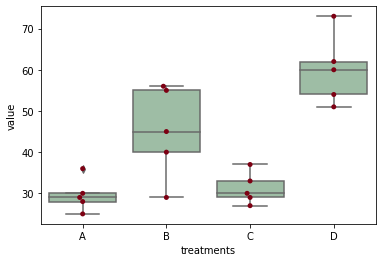

In [5]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

In [6]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


In [7]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


In [8]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary
# output (ANOVA F and p value)

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,3010.95,1003.650,17.49281,0.000026
Residual,16.0,918.00,57.375,NaN,NaN


In [9]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary
# output
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

/home/xenakas/.local/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


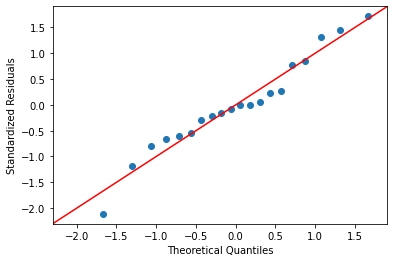

In [10]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

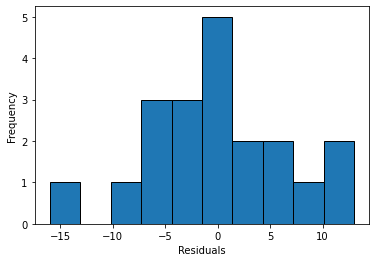

In [11]:
# histogram
plt.hist(res.anova_model_out.resid, bins=10, histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [12]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


In [13]:
import scipy.stats as stats
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)

5.687843565012841 0.1278253399753447


In [14]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary
# output

,Parameter,Value
0,Test statistics (T),5.6878
1,Degrees of freedom (Df),3.0000
2,p value,0.1278


In [15]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary
# output

,Parameter,Value
0,Test statistics (W),1.9220
1,Degrees of freedom (Df),3.0000
2,p value,0.1667


### Two-way ANOVA

In [16]:
import pandas as pd
import seaborn as sns
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


In [17]:
d_melt.shape

(54, 3)

<AxesSubplot:xlabel='Genotype', ylabel='value'>

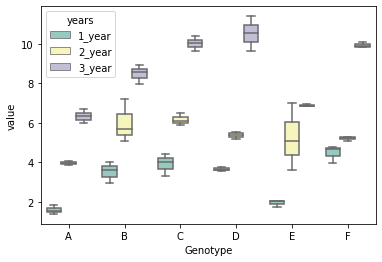

In [18]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt, palette="Set3") 

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


In [20]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.anova_summary
# output

,df,sum_sq,mean_sq,F,PR(>F)
C(Genotype),5.0,58.551733,11.710347,32.748581,1.931655e-12
C(years),2.0,278.925633,139.462817,390.014868,4.006243e-25
C(Genotype):C(years),10.0,17.122967,1.712297,4.788525,2.230094e-04
Residual,36.0,12.873000,0.357583,NaN,NaN


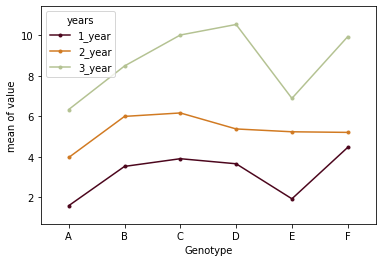

In [21]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=d_melt['Genotype'], trace=d_melt['years'], response=d_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()


In [22]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Genotype
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='Genotype', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.tukey_summary


# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

/home/xenakas/.local/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,2.040000,1.191912,2.888088,10.234409,0.001000
1,A,C,2.733333,1.885245,3.581421,13.712771,0.001000
2,A,D,2.560000,1.711912,3.408088,12.843180,0.001000
3,A,E,0.720000,-0.128088,1.568088,3.612145,0.135306
4,A,F,2.573333,1.725245,3.421421,12.910072,0.001000
5,B,C,0.693333,-0.154755,1.541421,3.478361,0.163609
6,B,D,0.520000,-0.328088,1.368088,2.608771,0.453066
7,B,E,1.320000,0.471912,2.168088,6.622265,0.001000
8,B,F,0.533333,-0.314755,1.381421,2.675663,0.425189
9,C,D,0.173333,-0.674755,1.021421,0.869590,0.900000


In [23]:
# for main effect years
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='years', anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary

/home/xenakas/.local/lib/python3.10/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,1_year,2_year,2.146667,1.659513,2.633821,15.230432,0.001
1,1_year,3_year,5.521667,5.034513,6.008821,39.175794,0.001
2,2_year,3_year,3.375000,2.887846,3.862154,23.945361,0.001


In [24]:
# for interaction effect between genotype and years
res.tukey_hsd(df=d_melt, res_var='value', xfac_var=['Genotype','years'], anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary.head()

/home/xenakas/.local/lib/python3.10/site-packages/bioinfokit/analys.py:369: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(A, 1_year)","(A, 2_year)",2.38,0.548861,4.211139,6.893646,0.002439
1,"(A, 1_year)","(A, 3_year)",4.75,2.918861,6.581139,13.758326,0.001000
2,"(A, 1_year)","(B, 1_year)",1.94,0.108861,3.771139,5.619190,0.028673
3,"(A, 1_year)","(B, 2_year)",4.41,2.578861,6.241139,12.773520,0.001000
4,"(A, 1_year)","(B, 3_year)",6.90,5.068861,8.731139,19.985779,0.001000


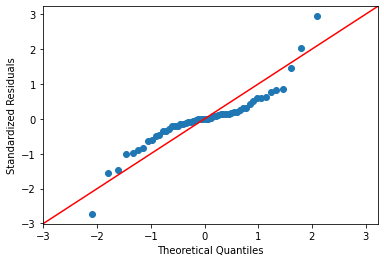

In [25]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

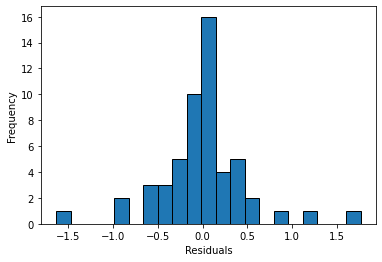

In [26]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [27]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

0.8978845477104187 0.00023986827000044286


In [28]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=d_melt, res_var='value', xfac_var=['Genotype', 'years'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.6849
1,Degrees of freedom (Df),17.0000
2,p value,0.0927


### One-way repeated measure ANOVA



In [ ]:
## Load and visualize the dataset

In [29]:
import pandas as pd
# load data file
df=pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/plants_leaves.csv")
df

,Id,W1,W2,W3,W4,W5
0,P1,4,5,6,8,10
1,P2,3,4,6,6,9
2,P3,6,7,9,10,12
3,P4,5,7,8,10,12
4,P5,5,6,7,8,10


In [30]:
# reshape the dataframe in long-format dataframe
df_melt = pd.melt(df.reset_index(), id_vars=['Id'], value_vars=['W1', 'W2', 'W3', 'W4', 'W5'])
# replace column names
df_melt.columns = ['Id', 'time_points', 'leaves']
df_melt.head(2)

,Id,time_points,leaves
0,P1,W1,4
1,P2,W1,3


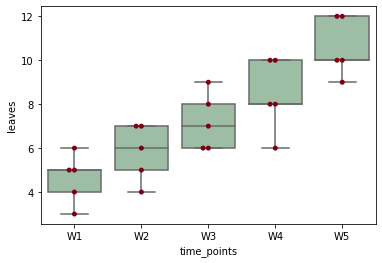

In [31]:
# generate a boxplot to see the data distribution by time points. Using boxplot, we can 
# boxplot helps detect the differences between different time points and find any outliers
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='time_points', y='leaves', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="time_points", y="leaves", data=df_melt, color='#7d0013')
plt.show()

In [ ]:
# Perform one-way repeated measure ANOVA

In [32]:
import pingouin as pg
res = pg.rm_anova(dv='leaves', within='time_points', subject='Id', data=df_melt, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time_points,108.24,4,27.060,146.27027,2.214820e-12,0.744224,0.541964
1,Error,2.96,16,0.185,NaN,NaN,NaN,NaN


/home/xenakas/.local/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/xenakas/.local/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
### Post-hoc tests

In [33]:
# install pingouin as !pip install pingouin
# make sure you have installed the pingouin package (pip install pingouin)
post_hocs = pg.pairwise_ttests(dv='leaves', within='time_points', subject='Id', padjust='fdr_bh', data=df_melt)
post_hocs

/home/xenakas/.local/lib/python3.10/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,time_points,W1,W2,True,True,-6.000000,4.0,two-sided,0.003883,0.004853,fdr_bh,13.991,-0.884977
1,time_points,W1,W3,True,True,-10.614456,4.0,two-sided,0.000446,0.000743,fdr_bh,68.116,-1.917450
2,time_points,W1,W4,True,True,-10.155927,4.0,two-sided,0.000529,0.000756,fdr_bh,60.047,-2.397193
3,time_points,W1,W5,True,True,-18.973666,4.0,two-sided,0.000045,0.000227,fdr_bh,369.333,-4.352931
4,time_points,W2,W3,True,True,-5.715476,4.0,two-sided,0.004636,0.005151,fdr_bh,12.3,-0.969840
5,time_points,W2,W4,True,True,-10.614456,4.0,two-sided,0.000446,0.000743,fdr_bh,68.116,-1.565591
6,time_points,W2,W5,True,True,-24.000000,4.0,two-sided,0.000018,0.000179,fdr_bh,740.006,-3.277318
7,time_points,W3,W4,True,True,-3.207135,4.0,two-sided,0.032678,0.032678,fdr_bh,3.006,-0.722581
8,time_points,W3,W5,True,True,-13.880442,4.0,two-sided,0.000156,0.000521,fdr_bh,147.775,-2.321433
9,time_points,W4,W5,True,True,-11.000000,4.0,two-sided,0.000388,0.000743,fdr_bh,75.445,-1.310253


In [ ]:
# Check repeated measure ANOVA assumptions
## Assumption of sphericity

In [34]:
# install pingouin as !pip install pingouin
# Mauchly’s test of sphericity
import pingouin as pg
pg.sphericity(data=df_melt, dv='leaves', subject='Id', within='time_points')

SpherResults(spher=True, W=0.1333930222643612, chi2=4.868267346520268, dof=9, pval=0.8883022484983495)

In [ ]:
## Assumption of normality

In [35]:
pg.normality(data=df_melt, dv='leaves', group='time_points')

,W,pval,normal
W1,0.960859,0.813953,True
W2,0.902020,0.421149,True
W3,0.902020,0.421149,True
W4,0.881038,0.314040,True
W5,0.851907,0.200623,True


### Two-way repeated measure ANOVA (Within-within-subjects ANOVA)


In [ ]:
## Load and visualize the dataset

In [37]:
import pandas as pd
# load data file
df=pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/plants_leaves_two_within.csv")
df


,plants,nutrient_level,year,time,num_leaves
0,P1,Low,Year1,Week1,4
1,P2,Low,Year1,Week1,3
2,P3,Low,Year1,Week1,6
3,P4,Low,Year1,Week1,5
4,P5,Low,Year1,Week1,5
5,P1,Low,Year1,Week2,5
6,P2,Low,Year1,Week2,4
7,P3,Low,Year1,Week2,7
8,P4,Low,Year1,Week2,7
9,P5,Low,Year1,Week2,6


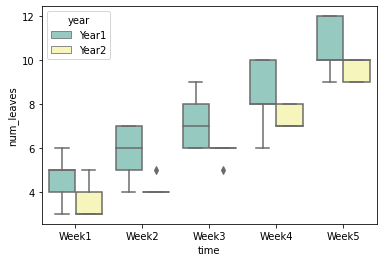

In [38]:
# In this dataset, there are two independent variables (time and year) and number of leaves (num_leaves)
# is a dependent variable

# generate a boxplot to see the data distribution by time points. Using boxplot, we can 
# boxplot helps detect the differences between different time points and find any outliers
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x="time", y="num_leaves", hue="year", data=df, palette="Set3")
plt.show()

In [ ]:
## Perform two-way repeated measure ANOVA

In [39]:
# install pingouin as !pip install pingouin
import pingouin as pg
res = pg.rm_anova(dv='num_leaves', within=['time', 'year'], subject='plants', 
                  data=df, detailed=True)
res

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,226.88,4,16,56.72,158.657343,1.177428e-12,0.000003,0.836331,0.421229
1,year,18.00,1,4,18.00,3.600000,1.306351e-01,0.130635,0.288462,1.000000
2,time * year,0.80,4,16,0.20,1.454545,2.620704e-01,0.291675,0.017699,0.441606


### Mixed

In [40]:
import pandas as pd
df=pd.read_csv("mixedanova.csv")

In [41]:
df

,id,genotype,before,after
0,1,A,1.53,4.08
1,2,A,1.83,4.84
2,3,A,1.38,4.26
3,4,A,1.92,4.35
4,5,A,1.30,4.79
5,6,B,3.60,5.70
6,7,B,2.94,5.07
7,8,B,3.00,6.00
8,9,B,2.95,5.00
9,10,B,2.12,3.98


In [42]:
# reshape the dataframe in long-format dataframe
df_melt = pd.melt(df.reset_index(), id_vars=['id', 'genotype'], value_vars=['before', 'after'])

In [43]:
#rename column; read more https://www.reneshbedre.com/blog/rename-column-names-pandas.html
df_melt.rename(columns={"variable": "fertilizer", "value": "yield"}, inplace=True)
df_melt.head(2)

,id,genotype,fertilizer,yield
0,1,A,before,1.53
1,2,A,before,1.83


In [44]:
from dfply import *
df_melt >> group_by(X.genotype, X.fertilizer) >> summarize(n=X['yield'].count(), mean=X['yield'].mean(), std=X['yield'].std())

,fertilizer,genotype,n,mean,std
0,after,A,5,4.464,0.335306
1,before,A,5,1.592,0.273075
2,after,B,5,5.150,0.778267
3,before,B,5,2.922,0.526802
4,after,C,5,3.194,0.339823
5,before,C,5,2.110,0.099750


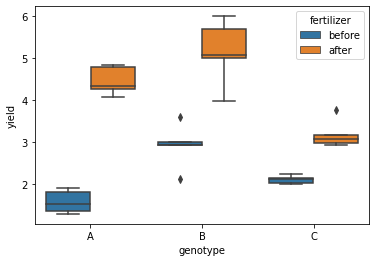

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='genotype', y='yield', hue='fertilizer', data=df_melt)
# ax = sns.swarmplot(x="genotype", y="yield", data=df_melt, color='#7d0013')

plt.show()


In [47]:
import pingouin as pg
pg.mixed_anova(dv='yield', between='genotype', within='fertilizer', subject='id', data=df_melt)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,10.242987,2,12,5.121493,16.351889,3.741297e-04,0.731566,NaN
1,fertilizer,31.868213,1,12,31.868213,373.404574,2.083410e-10,0.968864,1.0
2,Interaction,4.100347,2,12,2.050173,24.022184,6.371677e-05,0.800148,NaN


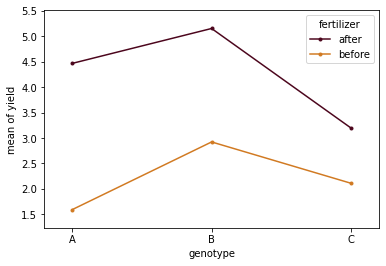

In [48]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=df_melt['genotype'], trace=df_melt['fertilizer'], response=df_melt['yield'], 
    colors=['#4c061d','#d17a22'])
plt.show()


In [49]:
import pingouin as pg
pg.sphericity(data=df_melt, dv='yield', subject='id', within='fertilizer')

(True, nan, nan, 1, 1.0)

In [50]:
df_melt['factor_comb']=df_melt["genotype"] + '-'+df_melt["fertilizer"]
pg.normality(df_melt, dv='yield', group='factor_comb')

,W,pval,normal
A-before,0.908932,0.461202,True
B-before,0.897502,0.396232,True
C-before,0.956608,0.784188,True
A-after,0.891106,0.362694,True
B-after,0.943001,0.687227,True
C-after,0.779155,0.054206,True


In [51]:
df_melt_before = pd.melt(df.reset_index(), id_vars=['id', 'genotype'], value_vars=['before'])
df_melt_after = pd.melt(df.reset_index(), id_vars=['id', 'genotype'], value_vars=['after'])

In [52]:
pg.homoscedasticity(df_melt_before, dv='value', group='genotype')

,W,pval,equal_var
levene,1.122517,0.35736,True


In [53]:
pg.homoscedasticity(df_melt_after, dv='value', group='genotype')

,W,pval,equal_var
levene,1.35042,0.295825,True


In [ ]:
# df

In [ ]:
# pg.box_m()

### ANCOVA

In [54]:
import pandas as pd
df=pd.read_csv("ancova_data.csv")
df.head(10)

,genotype,height,yield
0,A,10.0,20.0
1,A,11.5,22.0
2,A,12.0,24.0
3,A,12.9,24.0
4,A,13.4,26.0
5,A,14.2,27.0
6,A,15.0,27.0
7,A,15.9,27.2
8,A,16.6,27.0
9,A,16.4,27.5


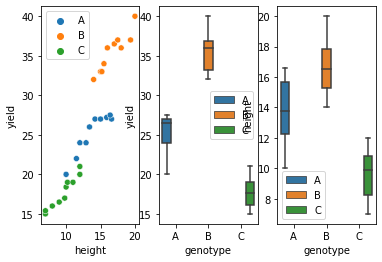

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=3)
sns.scatterplot(data=df, x="height", y="yield", hue=df.genotype.tolist(), ax=axs[0])
sns.boxplot(data=df, x="genotype", y="yield", hue=df.genotype.tolist(), ax=axs[1])
sns.boxplot(data=df, x="genotype", y="height", hue=df.genotype.tolist(), ax=axs[2])
plt.show()

In [56]:
from pingouin import ancova
ancova(data=df, dv='yield', covar='height', between='genotype')
# output

,Source,SS,DF,F,p-unc,np2
0,genotype,193.232458,2,141.352709,1.072947e-14,0.915777
1,height,132.695696,1,194.138152,1.429323e-13,0.881892
2,Residual,17.771304,26,NaN,NaN,NaN
